# Example 3 -- sparse $\Phi$

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm.auto import tqdm

from tick.hawkes import HawkesCumulantMatching
from tick.hawkes.inference.base import LearnerHawkesNoParam

In [46]:
import sys
sys.path.append('../simulation')
from simulation_v1 import *
from simulation_clust import simulate


sys.path.append('./')
from train_v1_sparse import theoretical_C_K_obs
from estim_v1_sparse import Optim_tf

sys.path.append('/home/users/ruan/ANotebook/spread/Models')
from dump_load import DataBox

from functions_v1 import compute_skew

In [47]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
#parameters setting
x = 0.3
y = 0.2
z = 0.1
w = 0.2
id_2 = np.eye(2)
alpha = np.block([[np.fliplr(id_2)*x, id_2*y],
                  [id_2*z, np.fliplr(id_2)*w]]) # 4*4
beta = 20

mu_tot = 1
#r is the proportion of exogenous order
r = 0.6
mu = (1-r) * mu_tot * np.ones((4))
lam = r * mu_tot * np.ones((2))
delay = 0.05
T = 2000
n_realizations = 100

print(np.linalg.eig(alpha)[0])

[-0.4  0.4 -0.1  0.1]


In [17]:
alpha

array([[0. , 0.3, 0.2, 0. ],
       [0.3, 0. , 0. , 0.2],
       [0.1, 0. , 0. , 0.2],
       [0. , 0.1, 0.2, 0. ]])

In [18]:
norm_phi = alpha
R = np.linalg.inv(np.eye(4) - norm_phi)
lamlam = np.concatenate((lam, lam))
Lp = R @ (mu + lamlam) # Lp[1] is the \Lambda price1+ process, sum of two processes
C = R @ (np.diag(Lp) + np.kron(np.array([[0,1],[1,0]]), np.diag(lam))) @ R.T

hawkes_to_price = np.array([[1, -1, 0, 0], [0, 0, 1, -1]])
Lam_price = np.array([[1, 1, 0, 0], [0, 0, 1, 1]]) @ Lp
C_price = hawkes_to_price @ C @ hawkes_to_price.T
correl_price = C_price[0,1] / np.sqrt(C_price[0,0] * C_price[1,1])
print('Cov micro:', Lam_price)
print('Cov macro:', C_price)
## print('Corrélation:', correl_price)

Cov micro: [3.7037037  2.96296296]
Cov macro: [[2.5416815  1.31169456]
 [1.31169456 2.25857836]]


In [19]:
## theorical C and K values
L_thr = tf.convert_to_tensor(Lp)
C_thr, K_thr = theoretical_C_K_obs(Lp, lamlam, R, only_ijj=True)

2022-11-07 10:42:06.484896: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-07 10:42:06.484947: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: clust3
2022-11-07 10:42:06.484960: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: clust3
2022-11-07 10:42:06.485046: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.43.4
2022-11-07 10:42:06.485078: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.43.4
2022-11-07 10:42:06.485101: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.43.4
2022-11-07 10:42:06.485638: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perf

## simulation

In [20]:
simulating = True

In [25]:
if simulating :
    times = simulate(mu, lam, alpha*beta, np.ones_like(alpha)*beta, delay, T, n_realizations)

  0%|          | 0/100 [00:00<?, ?it/s]

## estimated C and K from data

In [26]:
if simulating:
    for i in range(100):
        for j,ts in enumerate(times[i]):
            times[i][j] = np.array(ts)

In [27]:
if simulating : 
    integration_support = 1 # H 
    nphc = HawkesCumulantMatching(integration_support, 
                                  cs_ratio=.15, 
                                  tol=1e-10, 
                                  step=0.3)
    LearnerHawkesNoParam.fit(nphc, times, end_times=np.ones(len(times))*T)
    cumcal = nphc._cumulant_computer
    # estimate moments tick
    # estimator Λ
    cumcal.compute_L()
    L_est = cumcal.L
    # estimator C
    cumcal.compute_C_and_J()
    C_est = cumcal.C
    # estimator K
    K_est = compute_skew(cumcal)

In [28]:
if simulating :
    print(L_est, Lp)
    print(C_est, C_thr)    
    print(tf.linalg.diag_part(K_est))

[1.84398  1.83669  1.487865 1.478475] [1.85185185 1.85185185 1.48148148 1.48148148]
[[3.05981901 1.77709431 1.58588786 0.86140051]
 [1.77709431 2.96864576 0.86087273 1.47557707]
 [1.58588786 0.86087273 2.09198149 0.88725957]
 [0.86140051 1.47557707 0.88725957 1.95763441]] tf.Tensor(
[[3.09845955 1.8276188  1.53429462 0.87844734]
 [1.8276188  3.09845955 0.87844734 1.53429462]
 [1.53429462 0.87844734 1.98515976 0.85587057]
 [0.87844734 1.53429462 0.85587057 1.98515976]], shape=(4, 4), dtype=float64)
tf.Tensor(
[[6.92306973 4.4576192  2.63011865 1.5006245 ]
 [4.41988143 6.74058565 1.578484   2.18612346]
 [3.16006883 1.92336289 3.75184589 1.63887747]
 [1.98227015 2.873102   1.73414114 3.13750291]], shape=(4, 4), dtype=float64)


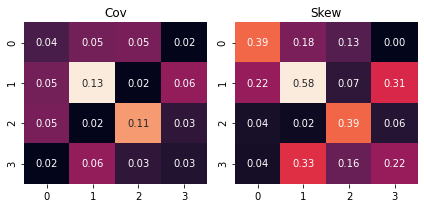

In [29]:
fig, axes = plt.subplots(1,2,figsize=(6,3))
sns.heatmap(np.abs(C_thr-C_est), ax=axes[0], annot=True, fmt='.2f', cbar=False)
sns.heatmap(np.abs(K_thr-tf.linalg.diag_part(K_est)), ax=axes[1], annot=True, fmt='.2f', cbar=False)
for i,mtx in enumerate(['Cov', 'Skew']):
    axes[i].set_title('%s'%(mtx))
fig.tight_layout()

## optimization

In [72]:
opt = Optim_tf(4)
L_obs = tf.convert_to_tensor(L_est)
C_obs = tf.convert_to_tensor(C_est)
K_obs = tf.convert_to_tensor(tf.linalg.diag_part(K_est))
opt.set_L_C_K(L_obs, C_obs, K_obs)

0.8144761890554486


In [73]:
# C_obs, K_obs

In [74]:
opt.set_init_value()
opt.set_variables()

[-0.07653728  0.07653728 -0.0140338   0.0140338 ]


In [75]:
opt.train(print_every=500, n_iter=5000)

Iter:  500
Loss:  437.075079341598
Iter:  1000
Loss:  437.06939580158706
Iter:  1500
Loss:  437.06939577312664
Iter:  2000
Loss:  437.0693957731184
Iter:  2500
Loss:  437.0693957731184
Iter:  3000
Loss:  437.06939577311954
Iter:  3500
Loss:  437.0693957731198
Iter:  4000
Loss:  437.06939577311977
Iter:  4500
Loss:  437.0693957731254
Iter:  5000
Loss:  437.06939577536195


[<tf.Variable 'phi:0' shape=(4,) dtype=float64, numpy=array([0.30350601, 0.16628194, 0.09914703, 0.20892932])>,
 <tf.Variable 'L:0' shape=(2,) dtype=float64, numpy=array([0.65389995, 0.65265924])>]

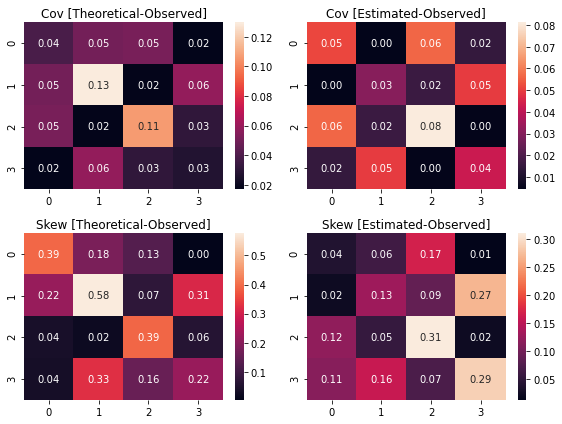

In [91]:
opt.reconstruct_C_K()
fig, axes = plt.subplots(2,2,figsize=(8,6))
sns.heatmap(np.abs(C_thr-opt.C_obs), ax=axes[0,0],annot=True, fmt='.2f')
sns.heatmap(np.abs(opt.C_obs-opt.C_opt), ax=axes[0,1],annot=True, fmt='.2f')
sns.heatmap(np.abs(K_thr-opt.K_obs), ax=axes[1,0],annot=True, fmt='.2f')
sns.heatmap(np.abs(opt.K_obs-tf.linalg.diag_part(opt.K_opt)), ax=axes[1,1],annot=True, fmt='.2f')
for i,mtx in enumerate(['Cov', 'Skew']):
    for j, err in enumerate(['Theoretical-Observed','Estimated-Observed']):
        axes[i,j].set_title('%s [%s]'%(mtx,err))
fig.tight_layout()

<AxesSubplot:>

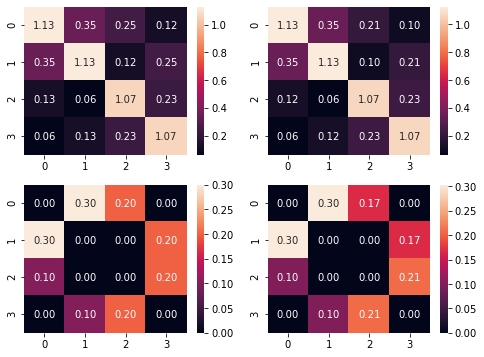

In [77]:

fig, axes = plt.subplots(2,2,figsize=(8,6))
sns.heatmap(R, ax=axes[0,0],annot=True, fmt='.2f')
sns.heatmap(opt.R_opt, ax=axes[0,1],annot=True, fmt='.2f')
sns.heatmap(alpha, ax=axes[1,0],annot=True, fmt='.2f')
sns.heatmap(opt.phi_opt, ax=axes[1,1],annot=True, fmt='.2f')

<AxesSubplot:>

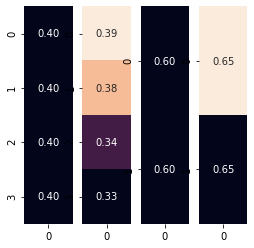

In [88]:
fig, axes = plt.subplots(1,4,figsize=(4,4))
sns.heatmap(np.expand_dims(mu,1), ax=axes[0],annot=True, fmt='.2f', cbar=False)
sns.heatmap(np.expand_dims(opt.mu_opt,1), ax=axes[1],annot=True, fmt='.2f', cbar=False)
sns.heatmap(np.expand_dims(lam,1), ax=axes[2],annot=True, fmt='.2f', cbar=False)
sns.heatmap(np.expand_dims(opt.L_opt,1), ax=axes[3],annot=True, fmt='.2f', cbar=False)



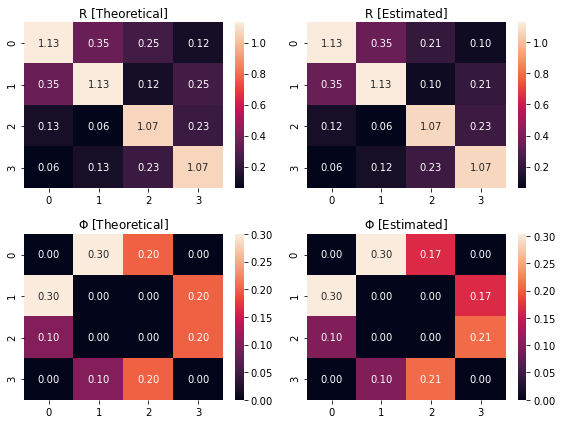

In [93]:
fig, axes = plt.subplots(2,2,figsize=(8,6))
sns.heatmap(R, ax=axes[0,0],annot=True, fmt='.2f')
sns.heatmap(opt.R_opt, ax=axes[0,1],annot=True, fmt='.2f')
sns.heatmap(alpha, ax=axes[1,0],annot=True, fmt='.2f')
sns.heatmap(opt.phi_opt, ax=axes[1,1],annot=True, fmt='.2f')
for i,mtx in enumerate(['R', r'$\Phi$']):
    for j, err in enumerate(['Theoretical','Estimated']):
        axes[i,j].set_title('%s [%s]'%(mtx,err))
fig.tight_layout()